# Version information

In [1]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: August 02, 2022
Pyleecan version:1.3.7


c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


SciDataTool version:1.4.24


# Analytical Air-Gap Surface Force Transfer
One of the main method to compute magnetic forces in electrical machine for vibroacoustic study is the Air-gap Surface Force (AGSF) method based on the Maxwell Stress Tensor (MST). The idea is to compute an equivalent magnetic pressure in the air-gap. However, there are two contradictory issue to take into account: 
- The magneto-static finite element solution contains minimal numerical error in the middle of the air-gap. 
- However, the theoretical application of the MST should be more accurate on the stator bore radius. 

To solve this issue, it is proposed to compute the AGSF at stator bore radius from the AGSF compute in the middle of the air-gap. It is based on the following scientific article: [PILE, Raphaël, LE BESNERAIS, Jean, PARENT, Guillaume, et al. Analytical study of air-gap surface force–application to electrical machines. Open Physics, 2020, vol. 18, no 1, p. 658-673.](https://www.degruyter.com/view/journals/phys/18/1/article-p658.xml)

This tutorial explains how to use the feature of Air-Gap Surface Force (AGSF) transfer in Pyleecan, and presents some numerical application for an SPMSM electrical machine. 

The notebook related to this tutorial is available on [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_AGSF_transfer.ipynb).

## Import Pyleecan modules and machine definition

In [2]:
import pytest
from os.path import join
from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Functions.load import load 
from pyleecan.definitions import DATA_DIR
# from Tests import save_validation_path as save_path

c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\pyleecan\Methods\Machine\Machine\plot.py:130: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


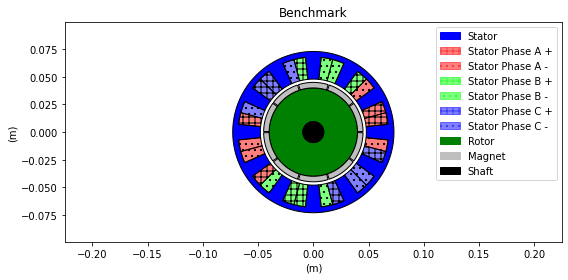

In [3]:
# %matplotlib notebook
# Load machine
Benchmark = load(join(DATA_DIR, "Machine", "Benchmark.json"))
Benchmark.plot()

## Simulation definition
The electromagnetic field is solved in a 2D magnetostatic simulation using FEMM software. The time dependancy is not considered in the following demonstration to lighten calculations. 

In [4]:
# Import Pyleecan modules
from numpy import exp, sqrt, pi
from os.path import join
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Classes.Output import Output
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR

# Load the machine
Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))

# Simulation initialization
simu = Simu1(name="FEMM_periodicity", machine=Benchmark)

# Definition of the enforced output of the electrical module
simu.input = InputCurrent(
#    Na_tot=252 * 8,
#    Nt_tot=50 * 8,
    Na_tot=5 * 2 ** 8, Nt_tot=2
)
# Set Id/Iq according to I0/Phi0
simu.input.OP = OPdq(N0=1000)
simu.input.OP.set_I0_Phi0(I0=250 / sqrt(2), Phi0=140*pi/180)

# Definition of the magnetic simulation: with periodicity

simu.elec = None
simu.force = ForceMT()
simu.mag = MagFEMM(
    is_periodicity_a=False,
    is_periodicity_t=False,
    nb_worker=4,
    is_sliding_band=False,
    Kmesh_fineness=4,
    type_BH_rotor=1,
    type_BH_stator=1
)
#simu.mag.Kmesh_fineness = 4
simu.force = ForceMT(is_periodicity_a=True, is_periodicity_t=True)

# Simu2 - Transfer Definition of the enforced output of the electrical module
simu2 = simu.copy()
simu2.mag.Kmesh_fineness = 4
simu2.force.is_agsf_transfer=True
simu2.force.max_wavenumber_transfer = 96


# Definition of the open-circuit simulation
simu2.input.OP.set_Id_Iq(Id=0,Iq=0)


# Run simulations
out = simu.run()
out2 = simu2.run()

[23:01:40] Starting running simulation FEMM_periodicity (machine=Benchmark)
[23:01:40] Starting Magnetic module
[23:01:42] Solving time step 2 / 2 in FEMM
[23:01:42] Solving time step 1 / 2 in FEMM
[23:02:37] Starting Force module
[23:02:37] In Force model, Nt_tot=2 is not divisible by the machine time periodicity (5). Time periodicity removed
[23:02:37] End of simulation FEMM_periodicity
[23:02:37] Starting running simulation FEMM_periodicity (machine=Benchmark)
[23:02:37] Starting Magnetic module
[23:02:39] Solving time step 1 / 2 in FEMM
[23:02:39] Solving time step 2 / 2 in FEMM
[23:03:31] Starting Force module
[23:03:31] In Force model, Nt_tot=2 is not divisible by the machine time periodicity (5). Time periodicity removed
[23:03:31] End of simulation FEMM_periodicity


## Validation of the AGSF transfer law at 90% of the air-gap
The air-gap is the area between the rotor bore radius (Rrbo) and the stator bore radius (Rsbo). The classic application of Maxwell stress tensor to compute AGSF is performed in the middle of the airgap (K=50%).

The next cell can be modified to perform several simulation with different radius of calculation for AGSF.
Now, the loop on simulation can be performed. For each values in K, the AGSF is either:

Directly extracted at the desired radius
or calculated from the knowledge of AGSF at K=50% using the transfer law.

In [5]:
# Tests at 90% of the air-gap (this list can be modified to add other cases)
K = [90]
Rsbo = 0.0480
Rrbo = 0.0450
Nk = len(K)

simu_list = list()
simu_list2 = list()

out_list = list()
out_list2 = list()

AGSF_list = list()
AGSF_list2 = list()

legend_list = list()
legend_list2 = list()

for ik in range(Nk):
    k = K[ik]
    Rag = (Rsbo - Rrbo) * k / 100 + Rrbo
    
    # Simu with is_agsf_transfer=False
    simu_list.append(simu.copy())
    simu_list[ik].mag.Rag_enforced = Rag
    out_list.append(simu_list[ik].run())
    legend_list.append(str(k) + "%")
    AGSF_list.append(out_list[ik].force.AGSF)
    
    # Simu2 with is_agsf_transfer=True
    simu_list2.append(simu2.copy())
    simu_list2[ik].force.Rsbo_enforced_transfer = Rag
    out_list2.append(simu_list2[ik].run())
    legend_list2.append(str(k) + "%")
    AGSF_list2.append(out_list2[ik].force.AGSF)
    



[09:30:25] Starting running simulation FEMM_periodicity (machine=Benchmark)
[09:30:25] Starting Magnetic module
[09:30:27] Solving time step 1 / 2 in FEMM
[09:30:28] Solving time step 2 / 2 in FEMM
[09:31:15] Starting Force module
[09:31:15] End of simulation FEMM_periodicity
[09:31:15] Starting running simulation FEMM_periodicity (machine=Benchmark)
[09:31:15] Starting Magnetic module
[09:31:17] Solving time step 2 / 2 in FEMM
[09:31:17] Solving time step 1 / 2 in FEMM
[09:32:02] Starting Force module
[09:32:02] End of simulation FEMM_periodicity


<IPython.core.display.Javascript object>


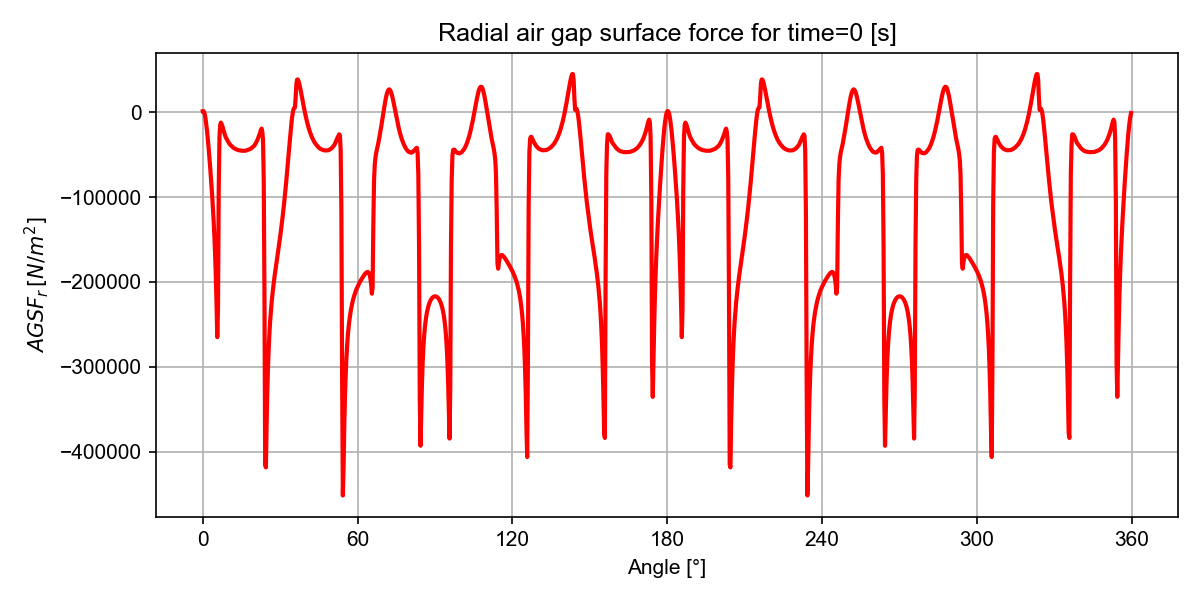

<IPython.core.display.Javascript object>


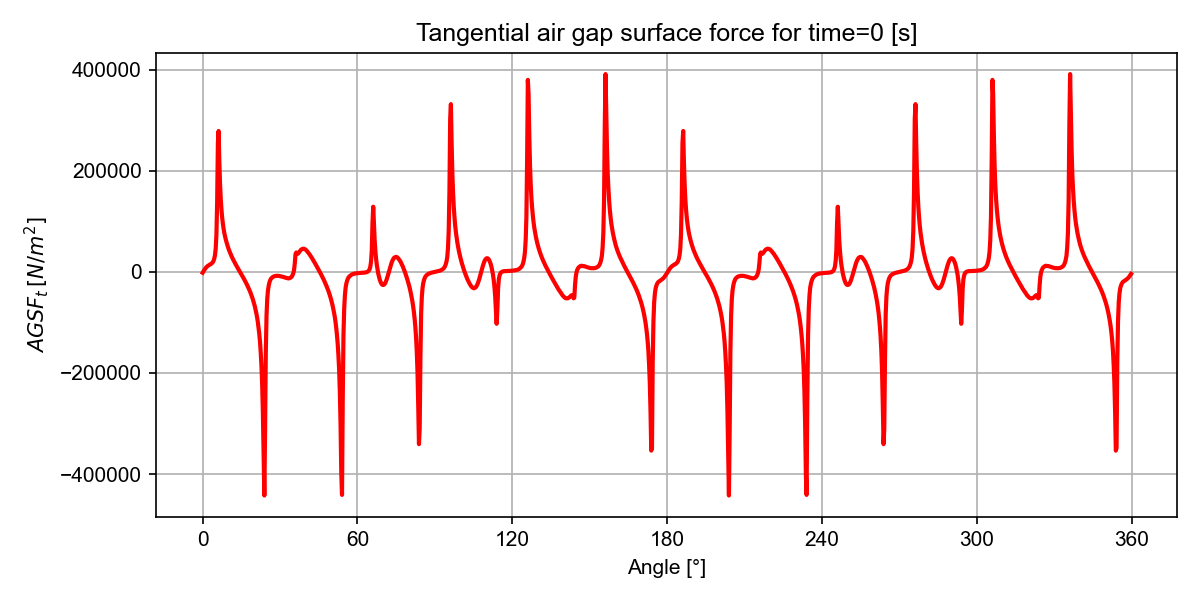

<IPython.core.display.Javascript object>


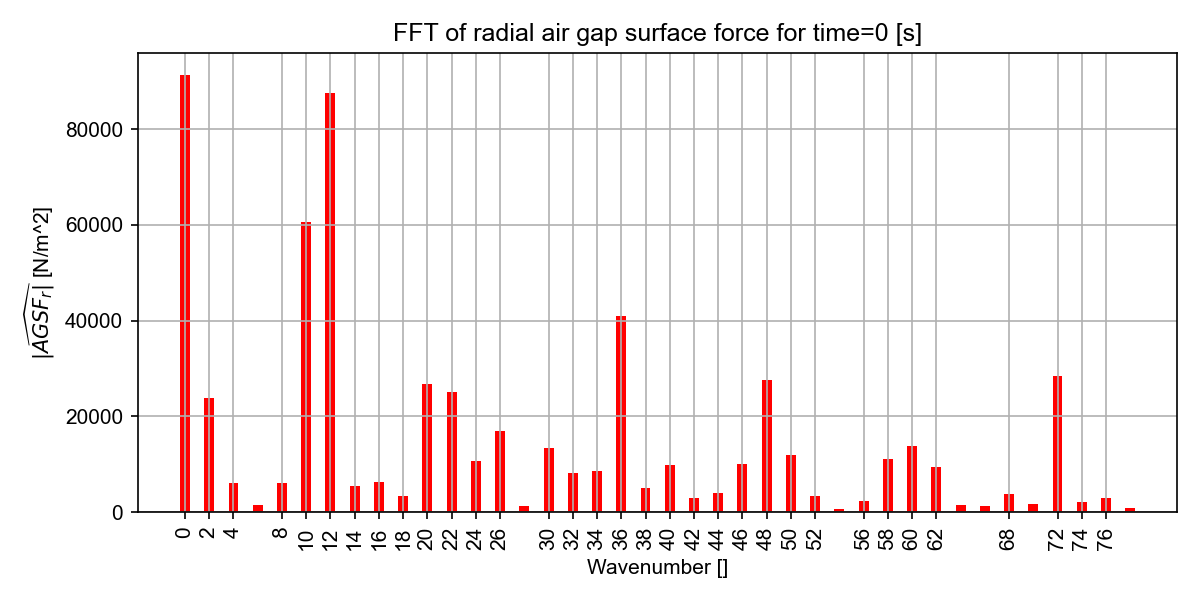

<IPython.core.display.Javascript object>


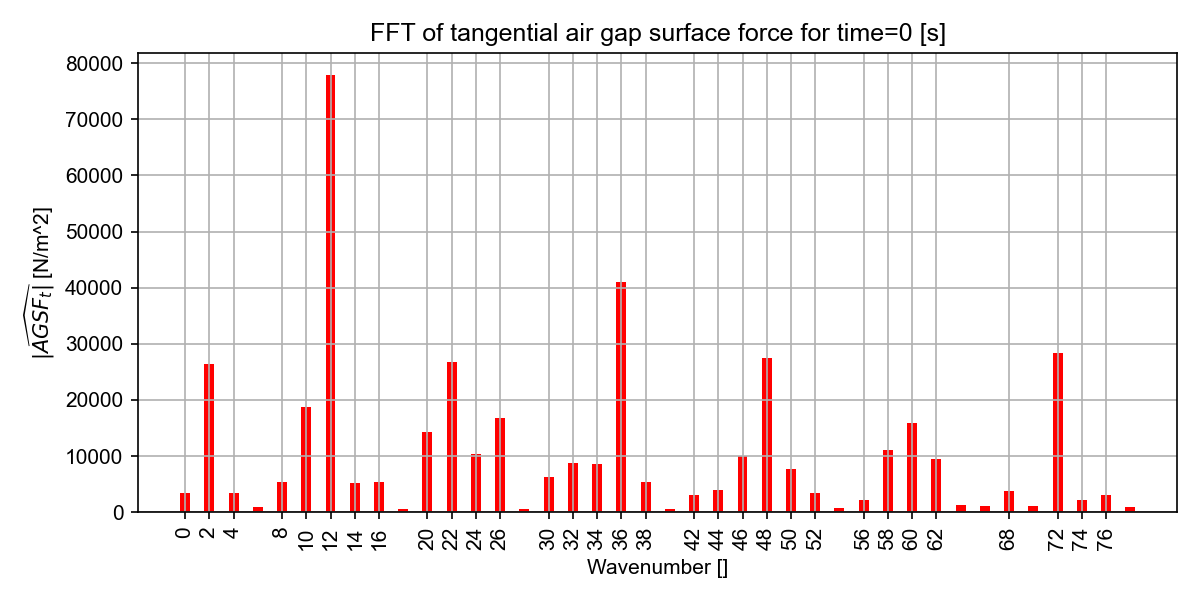

In [11]:
legend_list

from pyleecan.Functions.Plot import dict_2D, dict_3D
out_list[ik].force.AGSF.plot_2D_Data("angle{°}", **dict_2D)
out_list[ik].force.AGSF.plot_2D_Data("wavenumber=[0,78]", **dict_2D)

<IPython.core.display.Javascript object>


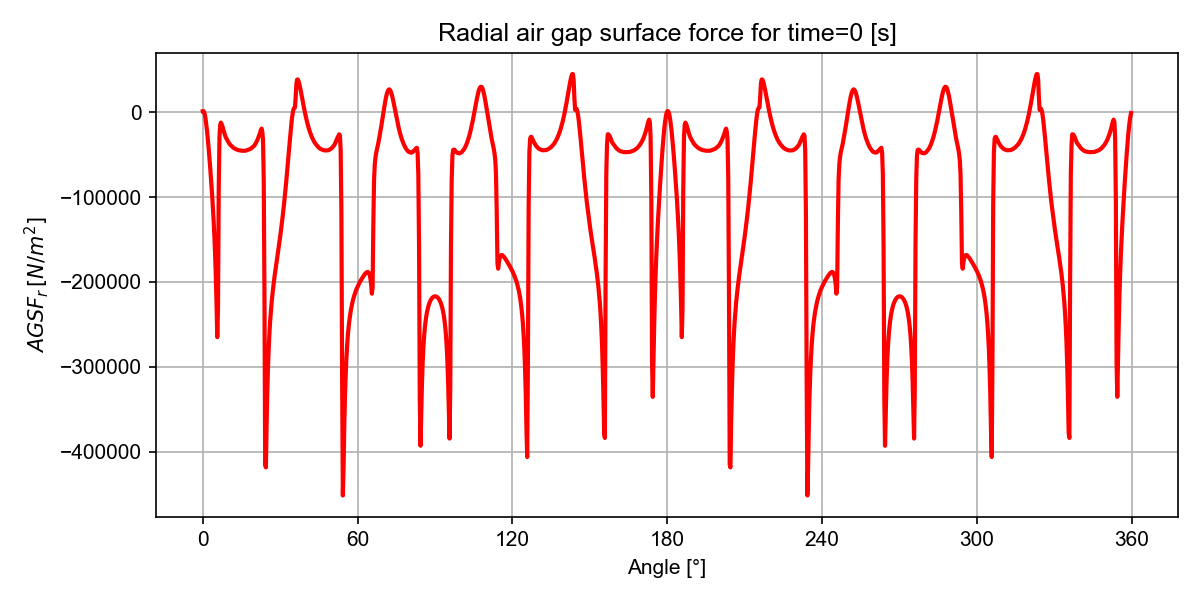

<IPython.core.display.Javascript object>


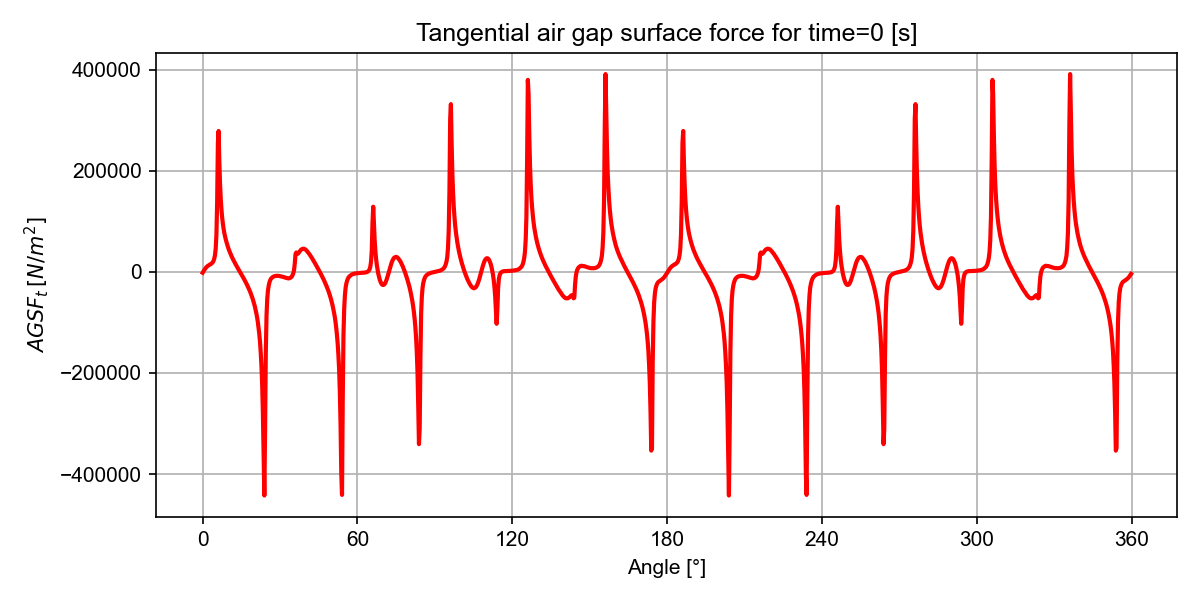

<IPython.core.display.Javascript object>


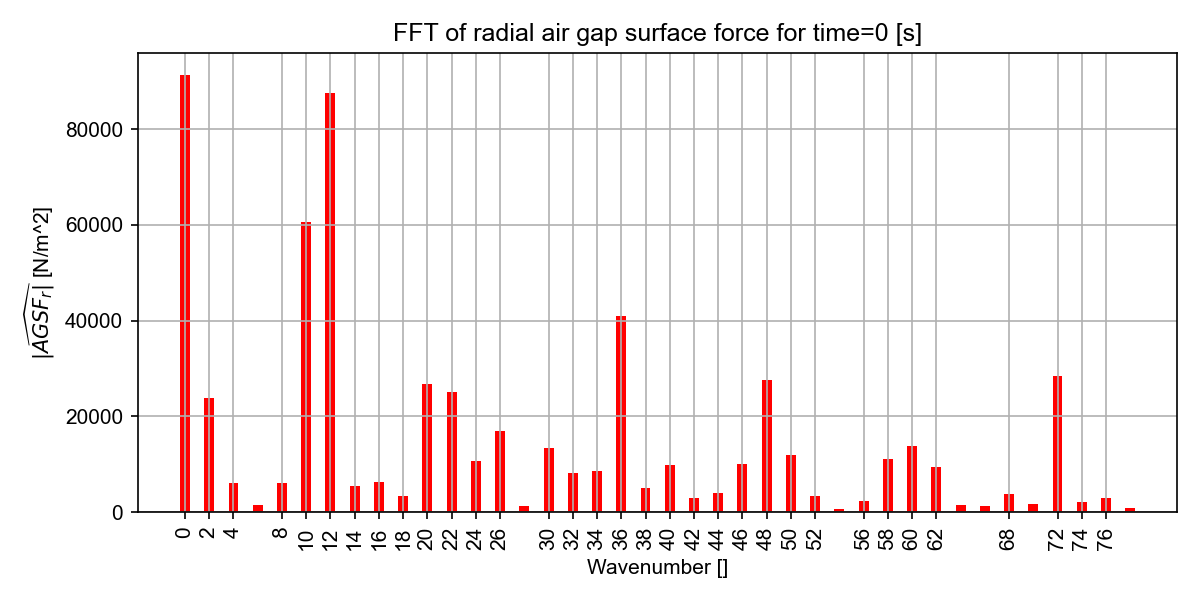

<IPython.core.display.Javascript object>


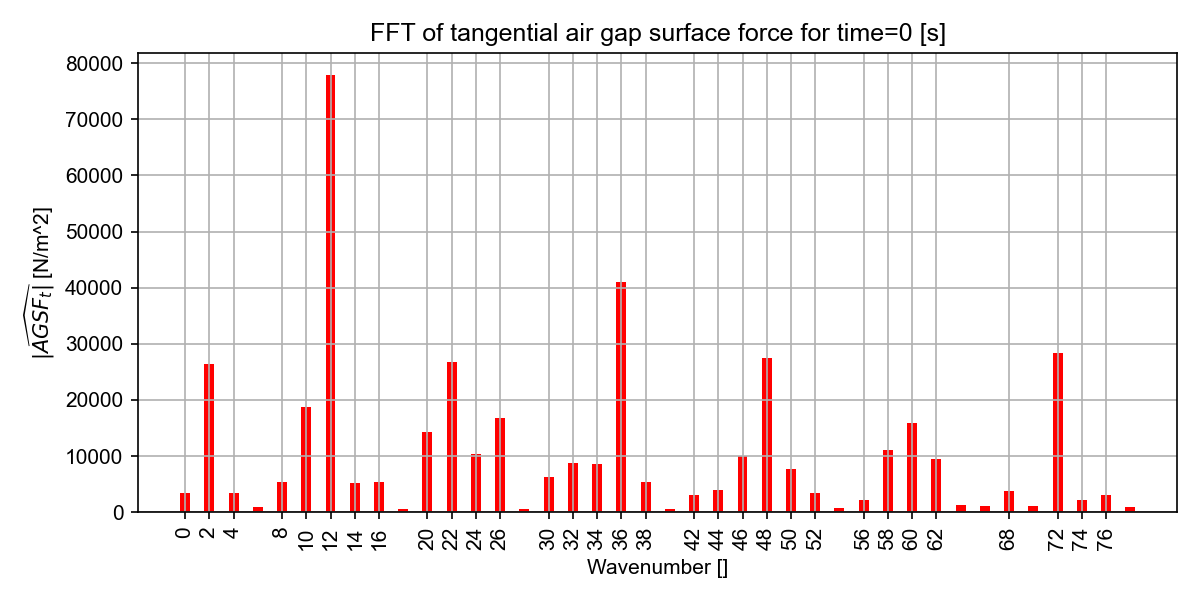

In [12]:
legend_list

from pyleecan.Functions.Plot import dict_2D, dict_3D
out_list[ik].force.AGSF.plot_2D_Data("angle{°}", **dict_2D)
out_list[ik].force.AGSF.plot_2D_Data("wavenumber=[0,78]", **dict_2D)

The results can be plotted to check the validity of the AGSF transfer law. For example, at 90% of the air-gap, there is a very good match between the transfer application and the direct method:

<IPython.core.display.Javascript object>


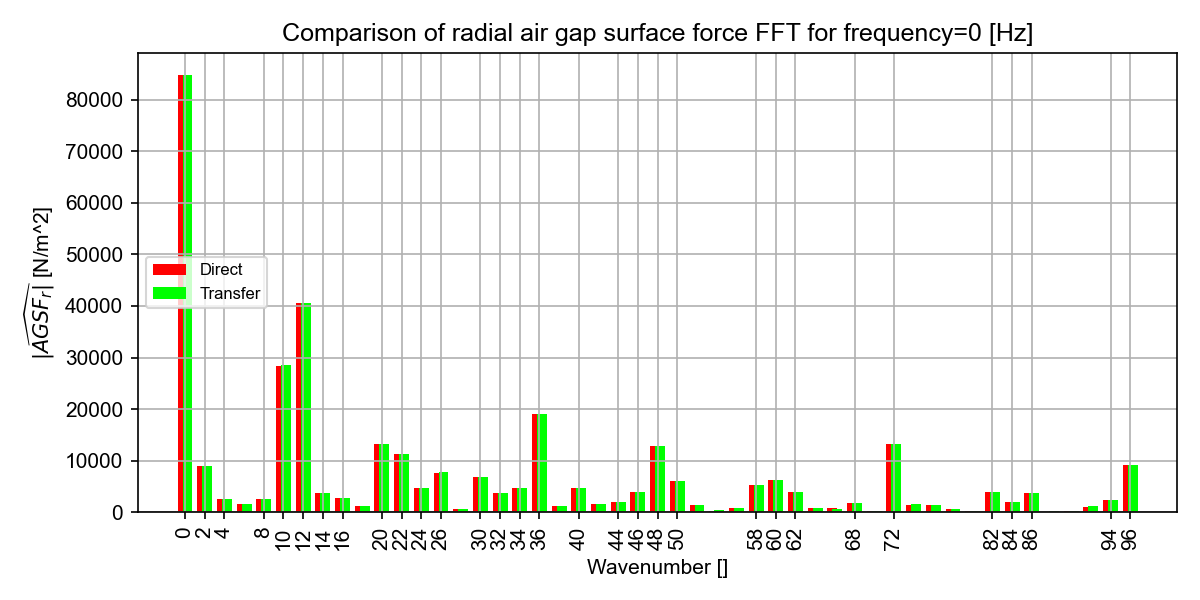

<IPython.core.display.Javascript object>


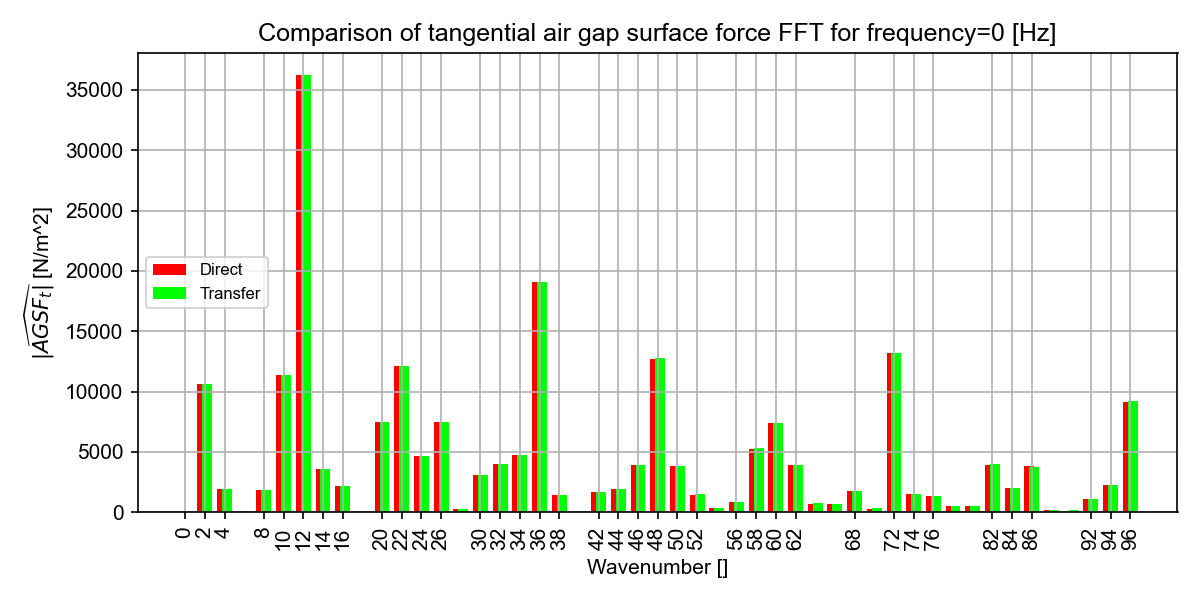

In [13]:
from pyleecan.Functions.Plot import dict_2D
ik = 0
out_list[ik].force.AGSF.plot_2D_Data(
    "wavenumber=[0,96]",
    "freqs=0", #equivalent to time=0 in this case
    data_list=[AGSF_list2[ik]],
    legend_list=["Direct", "Transfer"],
    is_show_fig=True,
    **dict_2D
)

## Demonstration of the accuracy improvement at 99% of the air-gap
The AGSF transfer results are compared to 2 different simulations in order to show the benefits in term of accuracy:
- A simulation with a coarse mesh, which is also used as input for the AGSF transfer
- and a simulation with a fine mesh which is the reference.

For all simulations, the compared output is the AGSF at 99% of the air-gap radius. 


In [16]:
Rs = (Rsbo - Rrbo) * 99 / 100 + Rrbo

simu2 = simu.copy()
simu2.force.is_agsf_transfer = True
simu2.force.Rsbo_enforced_transfer = Rs
simu2.force.max_wavenumber_transfer = 100

out2 = simu2.run()

# Enforced Rag for ref
simu.mag.Rag_enforced = Rs
out = simu.run()

# Simu with low finesness
simu3 = simu.copy()
simu3.mag.Kmesh_fineness = 1
out3 = simu3.run()

[19:01:11] Starting running simulation FEMM_periodicity (machine=Benchmark)
[19:01:11] Starting Magnetic module
[19:01:13] Solving time step 1 / 2 in FEMM
[19:01:13] Solving time step 2 / 2 in FEMM
[19:01:55] Starting Force module
[19:01:55] End of simulation FEMM_periodicity
[19:01:55] Starting running simulation FEMM_periodicity (machine=Benchmark)
[19:01:55] Starting Magnetic module
[19:01:57] Solving time step 2 / 2 in FEMM
[19:01:57] Solving time step 1 / 2 in FEMM
[19:02:48] Starting Force module
[19:02:48] End of simulation FEMM_periodicity
[19:02:48] Starting running simulation FEMM_periodicity (machine=Benchmark)
[19:02:48] Starting Magnetic module
[19:02:52] Solving time step 2 / 2 in FEMM
[19:02:52] Solving time step 1 / 2 in FEMM
[19:02:54] Starting Force module
[19:02:54] End of simulation FEMM_periodicity


The comparison is performed in the plot below. This significative results are observed in the tangential direction. The improvement can be observed since the AGSF computed with transfer law from the coarse mesh is more accurate on most wavenumbers with respect to the fine mesh. 

<IPython.core.display.Javascript object>


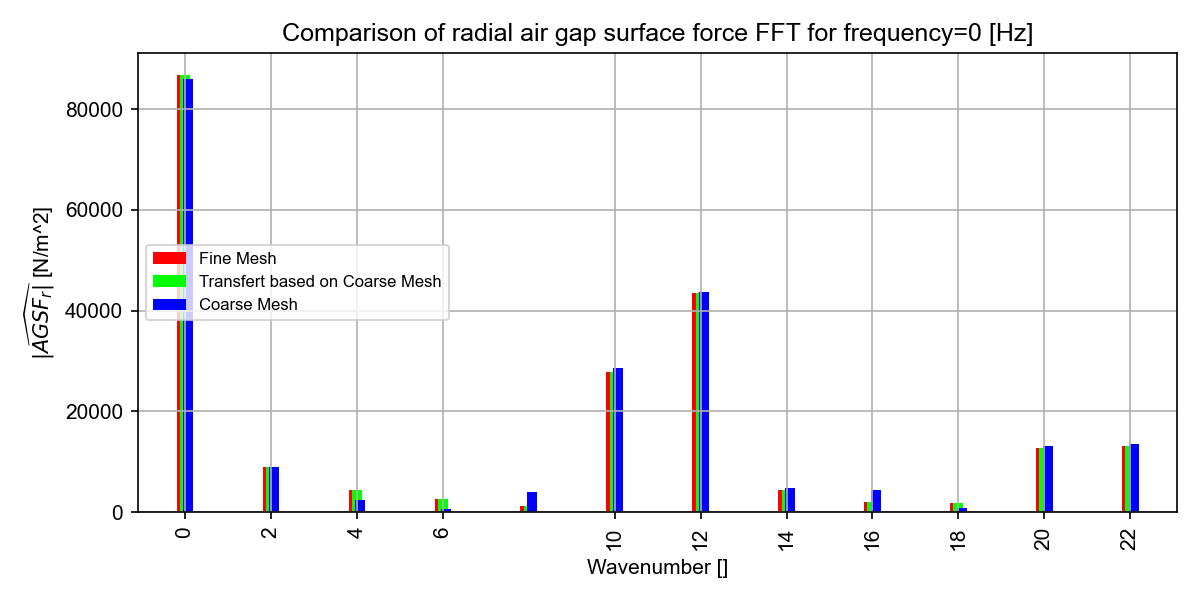

<IPython.core.display.Javascript object>


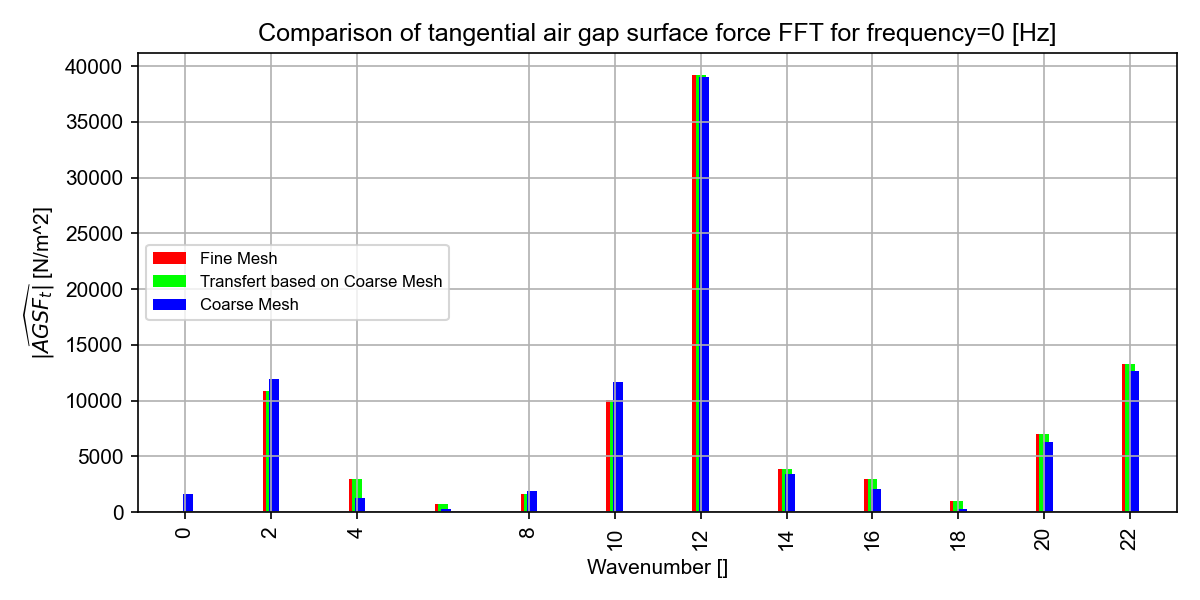

In [17]:
AGSF_list = list()
AGSF_list.append(out2.force.AGSF)
AGSF_list.append(out3.force.AGSF)
legend_list = ["Fine Mesh", "Transfert based on Coarse Mesh", "Coarse Mesh"]

out.force.AGSF.plot_2D_Data(
    "wavenumber=[0,22]",
    "freqs=0", #equivalent to time=0 in this case
    data_list=AGSF_list,
    legend_list=legend_list,
    is_show_fig=True,
    **dict_2D
)

<IPython.core.display.Javascript object>


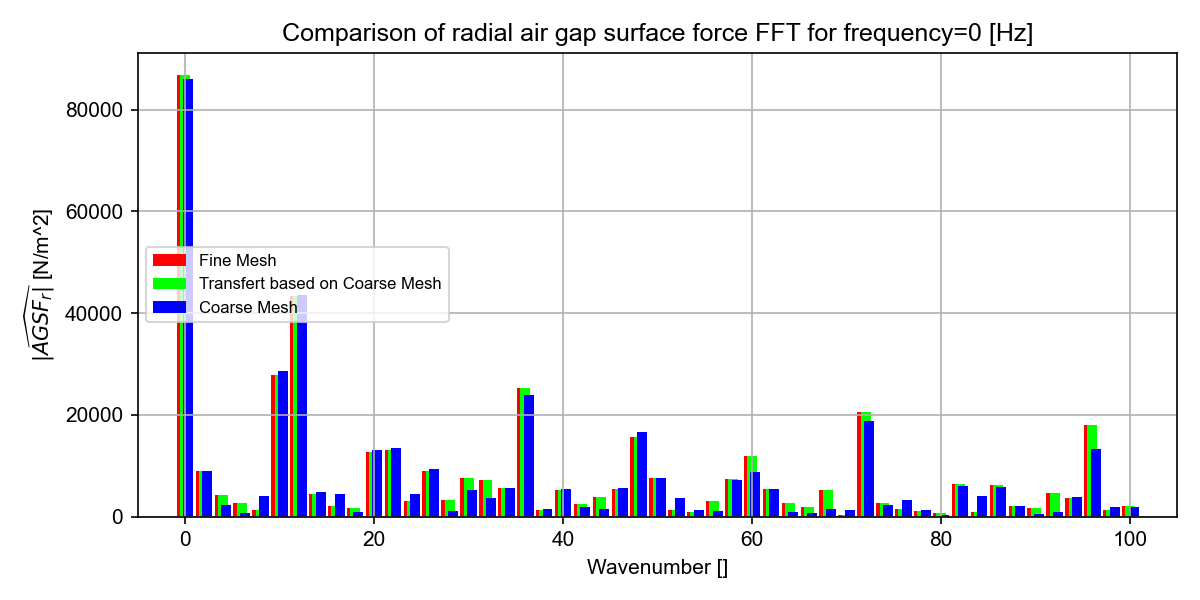

<IPython.core.display.Javascript object>


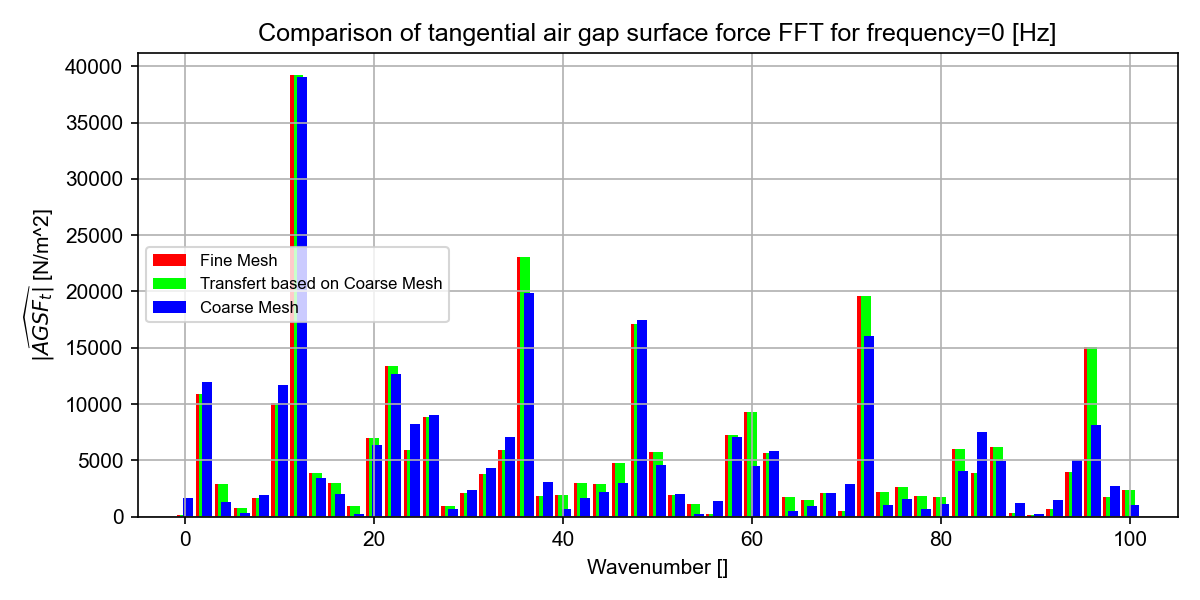

In [18]:
out.force.AGSF.plot_2D_Data(
    "wavenumber=[0,100]",
    "freqs=0", #equivalent to time=0 in this case
    data_list=AGSF_list,
    legend_list=legend_list,
    is_show_fig=True,
    is_auto_ticks = False,
    **dict_2D
)